In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import torch
from torchvision import transforms
import torchvision.datasets as dsets

c:\Users\govind.r\Anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
np.random.seed(0)

# Prepare the data
num_samples = 20
num_classes = 3
X = np.random.rand(num_samples, 4)
y = np.random.randint(0, num_classes, size=(num_samples,))

clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)

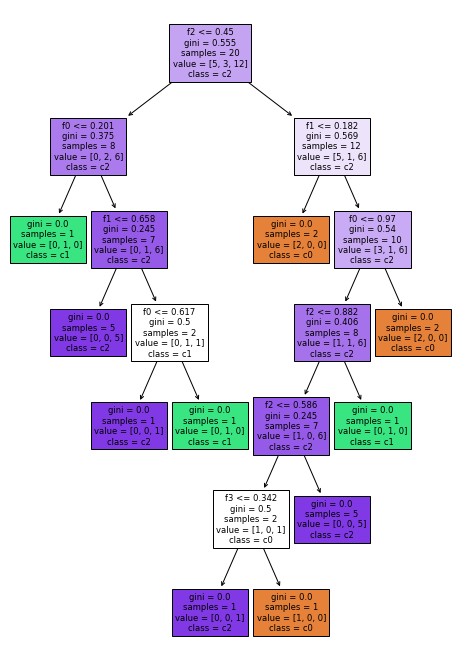

[0.96366276 0.38344152 0.79172504 0.52889492]


array([0])

In [10]:
fig = plt.figure(figsize=(8, 12))
_ = tree.plot_tree(clf, 
                   feature_names=[f'f{i}' for i in range(X.shape[1])],  
                   class_names=[f'c{i}' for i in set(y)],
                   filled=True)
plt.show()

print(X[2])
clf.predict([[.9, .2, .5, .343]])

In [4]:
class Node():
    def __init__(self, id):
        self.id = id
        self.left = None
        self.right = None
        self.parent = None
        self.cls = None

        
def unpack_tree(clf):
    root = Node(0)

    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    stack = [root]

    while len(stack) > 0:
        nxt = stack.pop()
        node_id = nxt.id

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            left_node = Node(children_left[node_id])
            right_node = Node(children_right[node_id])

            left_node.parent = right_node.parent = nxt
            nxt.left = left_node
            nxt.right = right_node

            stack.append(left_node)
            stack.append(right_node)
        else:
            nxt.cls = clf.tree_.value[nxt.id].argmax()

    return root, feature, threshold


def bfs(start, target_cls=2):
    queue = [(start, [])]
    visited = [start.id]

    while len(queue) > 0:
        node, path = queue[0]
        queue = queue[1:]

        if node.cls == target_cls:
            return path

        neighbours = []
        if node.parent and node.parent.id not in visited:
            neighbours.append((node.parent, path + ['parent']))
        if node.left and node.left.id not in visited:
            neighbours.append((node.left, path + ['left']))
        if node.right and node.right.id not in visited:
            neighbours.append((node.right, path + ['right']))

        for neighbour in neighbours:
            queue.append(neighbour)
            visited.append(neighbour[0].id)

            
# Starting from the root node, travel to the leaf node
# that predicts a sample
def traverse_to_node(node, sample, feature, threshold):
    path = []
    while True:
        path.append(node.id)
        if sample[feature[node.id]] <= threshold[node.id]:
            if node.left is None:
                break
            else:
                node = node.left
        else:
            if node.right is None:
                break
            else:
                node = node.right
    return node, np.array(path)


def create_adv_example(clf, sample, target_cls=0):
    root, feature, threshold = unpack_tree(clf)
    
    adv_sample = sample.copy()

    # Get the leaf node
    node, _ = traverse_to_node(root, sample, feature, threshold)

    # Get the shortest path from the leaf node to the target class's leaf node
    path = bfs(node, target_cls=target_cls)
    # Index of the top-most parent
    ix = path[::-1].index('parent')

    # Travel up to the top-most parent
    for dir in path[:-ix]:
        node = node.parent

    # Change each feature in the remaining path
    for dir in path[-ix:]:
        thresh = threshold[node.id]
        feat = feature[node.id]

        if dir == 'left':
            if adv_sample[feat] > thresh:
                adv_sample[feat] = thresh - 1e-3
            node = node.left
        else:
            if adv_sample[feat] <= thresh:
                adv_sample[feat] = thresh + 1e-3
            node = node.right

    return adv_sample

In [6]:
sample = X[1]
print(sample)
print(clf.predict([sample]))

def create_adv_examples(clf, sample, num_classes=num_classes):
    actual_label = clf.predict([sample])[0]
    adv_samples = []

    for target_cls in range(num_classes):
        if target_cls == actual_label:
            continue
        adv_samples.append(
            create_adv_example(
                clf,
                sample,
                target_cls=target_cls
            )
        )

    target_cls = 0
    for adv_sample in adv_samples:
        if target_cls == actual_label:
            target_cls += 1
        assert clf.predict([adv_sample])[0] == target_cls
        target_cls += 1
    
    return adv_samples

adv_samples = create_adv_examples(clf, sample)

[0.4236548  0.64589411 0.43758721 0.891773  ]
[2]


In [32]:
# Trying on MNIST
train_data = dsets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

X, y = [], []
X_test, y_test = [], []

for row in train_data:
    X.append(row[0])
    y.append(row[1])

for row in test_data:
    X_test.append(row[0])
    y_test.append(row[1])

X = torch.vstack(X)
X = X.reshape(X.shape[0], -1).numpy()
y = np.array(y)
X_test = torch.vstack(X_test)
X_test = X_test.reshape(X_test.shape[0], -1).numpy()
y_test = np.array(y_test)

clf = DecisionTreeClassifier(random_state=1234)
print('Starting training')
model = clf.fit(X, y)
print('Done')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Starting training
Done


In [33]:
y_pred = clf.predict(X_test)
accuracy = (y_pred == y_test).sum() / y_test.shape[0]
print(f'Accuracy: {accuracy}')

Accuracy: 0.8772


Number of pixels changed:
3
2
2
2
2
1
1
3
3


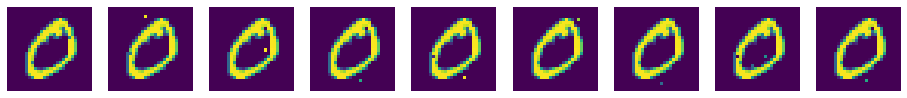

In [34]:
sample = X[1]

adv_samples = create_adv_examples(clf, sample, num_classes=10)

print('Number of pixels changed:')
for adv_sample in adv_samples:
    print((adv_sample != X[1]).sum())

f, ax = plt.subplots(1, 9)
f.set_figwidth(16)

for i in range(9):
    ax[i].imshow(adv_samples[i].reshape(28, 28))
    ax[i].axis("off")

plt.show()

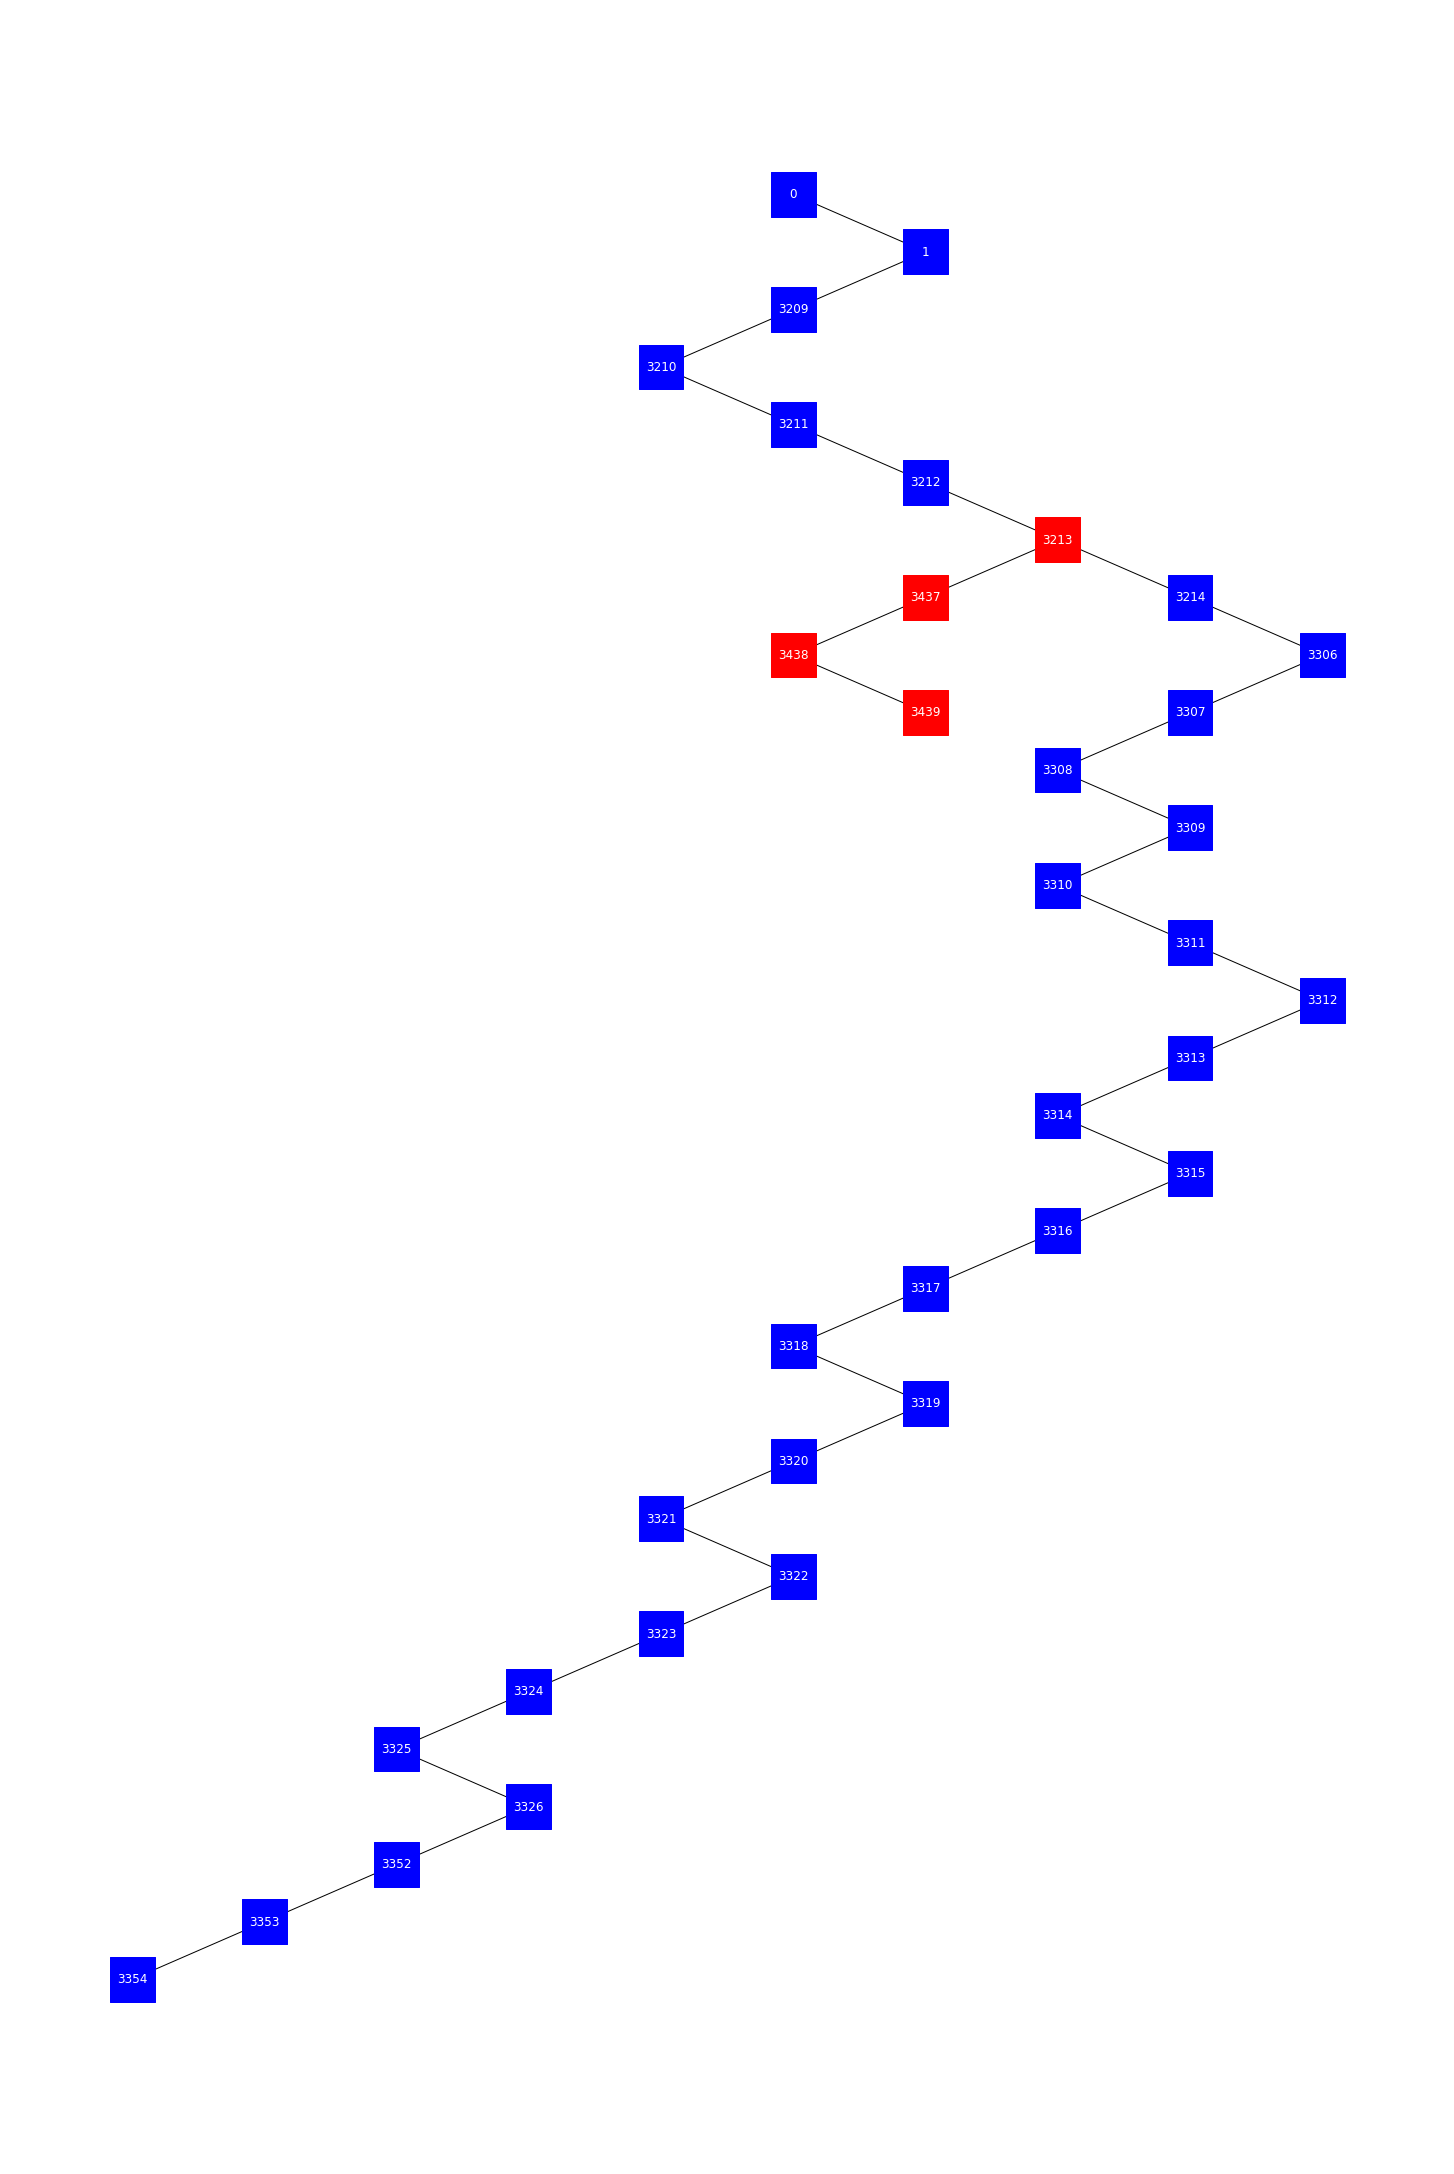

In [35]:
import networkx as nx
import pylab as plt

np.random.seed(1)
G = nx.Graph()

root, feature, threshold = unpack_tree(clf)
_, decision_path_original = traverse_to_node(root, X[1], feature, threshold)
_, decision_path_adv = traverse_to_node(root, adv_samples[0], feature, threshold)

first_branch = True
ln = len(decision_path_original)
offset = .5
val_map = {}

for i in range(ln):
    dir = np.random.choice([-.1, .1])
    offset += dir
    G.add_node(decision_path_original[i], pos=(offset, ln - i))
    if i < decision_path_adv.shape[0] and decision_path_adv[i] != decision_path_original[i]:
        if first_branch:
            offset_branch = offset - 2 * dir
            G.add_node(decision_path_adv[i], pos=(offset_branch, ln - i))
            G.add_edge(decision_path_original[i - 1], decision_path_adv[i])
            val_map[decision_path_original[i - 1]] = 'red'
            
            first_branch = False
        else:
            offset_branch -= dir
            G.add_node(decision_path_adv[i], pos=(offset_branch, ln - i))
            G.add_edge(decision_path_adv[i - 1], decision_path_adv[i])
            
        val_map[decision_path_adv[i]] = 'red'

    if i > 0:
        G.add_edge(decision_path_original[i - 1], decision_path_original[i])


values = [val_map.get(node, 'blue') for node in G.nodes()]
        
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=values, font_color='white', node_shape='s')

plt.rcParams['figure.figsize'] = [20, 30]
plt.show()